In [1]:
!pip install -q --no-deps siuba==0.4.4

In [2]:
import numpy as np
import pandas as pd
import os
from siuba import *
from plotnine import *
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import shapiro
from scipy import stats
from statsmodels.distributions.copula.api import GumbelCopula
import statsmodels.api as sm
from datetime import datetime

In [3]:
# Mulltinoullis c/ independiente
def multinoulliInd(p1, p2):
  u = np.random.uniform()
  if u < p1:
    i1 = 1
  else:
    i1 = 0
  if u < p2:
    i2 = 1
  else:
    i2 = 0
  j1 = i1
  if np.random.uniform() < p2:
    j2 = 1
  else:
    j2 = 0
  return(i1, i2, j1, j2)

In [4]:
# Procesos Poisson

def procesoPois(l, T):
  n = np.random.poisson(l*T)
  if n != 0:
    vectorUnif = np.random.uniform(low=0, high=T, size=n)
    t = np.sort(vectorUnif)
    Xt = np.arange(1,len(t)+1)
    # Hacemos que el proceso inicie en cero con cero conteos
  else:
    t = [0]
    Xt = [0]
  return t, Xt

In [5]:
# MonteCarlo

np.random.seed(2025)

m1 = 16
s1 = 0.002

m2 = 17
s2 = 0.003

procesos_MonteCarlo = pd.DataFrame()

for j in range(100000):

  # Proceso 1
  t1, Xt1 = procesoPois(5, 12)
  # Proceso 2
  t2, Xt2 = procesoPois(3, 12)
  # Proceso 3
  t3, Xt3 = procesoPois(6, 12)

  proceso1 = pd.DataFrame({'t': t1, 'Xt': Xt1, 'Proceso':'1'})
  proceso2 = pd.DataFrame({'t': t2, 'Xt': Xt2, 'Proceso':'2'})
  proceso3 = pd.DataFrame({'t': t3, 'Xt': Xt3, 'Proceso':'3'})

  procesos = pd.concat([proceso1, proceso2, proceso3])

  # Revisamos cuántos eventos hubieron en cada shock
  N1 = proceso1.shape[0]
  N2 = proceso2.shape[0]
  N3 = proceso3.shape[0]

  tablaMult1 = [multinoulliInd(0.3, 0.2) for i in range(N1)]
  tablaMult1 = pd.DataFrame(tablaMult1, columns=['I1','I2','I1_ind','I2_ind'])

  tablaMult2 = [multinoulliInd(0.4, 0.5) for i in range(N2)]
  tablaMult2 = pd.DataFrame(tablaMult2, columns=['I1','I2','I1_ind','I2_ind'])

  tablaMult3 = [multinoulliInd(0.3, 0.7) for i in range(N3)]
  tablaMult3 = pd.DataFrame(tablaMult3, columns=['I1','I2','I1_ind','I2_ind'])

  tablaMult = pd.concat([tablaMult1, tablaMult2, tablaMult3])

  procesos = pd.concat([procesos, tablaMult], axis=1)

  procesos = (procesos >> arrange(_.t) >>
             mutate(X1 = np.random.lognormal(m1,s1,size=len(procesos)),
                    X2 = np.random.lognormal(m2,s2,len(procesos)),
                    Severidad1 = _.X1*_.I1,
                    Severidad2 = _.X2*_.I2,
                    Severidad1_ind = _.X1*_.I1_ind,
                   Severidad2_ind = _.X2*_.I2_ind) >>
              mutate(Trayectoria = j)
          )

  procesos_MonteCarlo = pd.concat([procesos_MonteCarlo, procesos])

In [6]:
os.chdir(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación")
procesos_MonteCarlo = pd.read_csv("procesos_MonteCarlo.csv")

In [7]:
procesos_MonteCarlo

,Unnamed: 0,t,Xt,Proceso,I1,I2,I1_ind,I2_ind,X1,X2,Severidad1,Severidad2,Severidad1_ind,Severidad2_ind,Trayectoria
0,0,0.038053,1,1,0,0,0,0,8.894778e+06,2.419305e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0
1,1,0.175528,2,1,1,0,1,0,8.881306e+06,2.416811e+07,8.881306e+06,0.000000e+00,8.881306e+06,0.000000e+00,0
2,2,0.302670,3,1,0,0,0,1,8.901672e+06,2.409192e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.409192e+07,0
3,0,0.306964,1,3,0,1,0,1,8.877121e+06,2.411341e+07,0.000000e+00,2.411341e+07,0.000000e+00,2.411341e+07,0
4,0,0.353692,1,2,0,0,0,1,8.904756e+06,2.416461e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.416461e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16798356,37,11.686291,38,2,1,1,1,0,8.871444e+06,2.404592e+07,8.871444e+06,2.404592e+07,8.871444e+06,0.000000e+00,99999
16798357,59,11.753534,60,1,0,0,0,0,8.885467e+06,2.425190e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99999
16798358,60,11.755571,61,1,0,0,0,0,8.883036e+06,2.415878e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99999
16798359,84,11.783520,85,3,0,1,0,1,8.890774e+06,2.415371e+07,0.000000e+00,2.415371e+07,0.000000e+00,2.415371e+07,99999


In [8]:
procesos_MonteCarlo_Severidad_dep = (procesos_MonteCarlo >> 
                                     mutate(SeveridadAcumulada = _.Severidad1 + _.Severidad2) >> 
                                     group_by(_.Trayectoria) >> 
                                     summarize(SeveridadAcumulada = _.SeveridadAcumulada.sum())
                                    )

procesos_MonteCarlo_Severidad_ind = (procesos_MonteCarlo >> 
                                     mutate(SeveridadAcumulada_ind = _.Severidad1_ind + _.Severidad2_ind) >>
                                     group_by(_.Trayectoria) >> 
                                     summarize(SeveridadAcumulada_ind = _.SeveridadAcumulada_ind.sum())
                                    )

C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_dep
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 149'. Pick better value with 'binwidth'.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 149'. Pick better value with 'binwidth'.


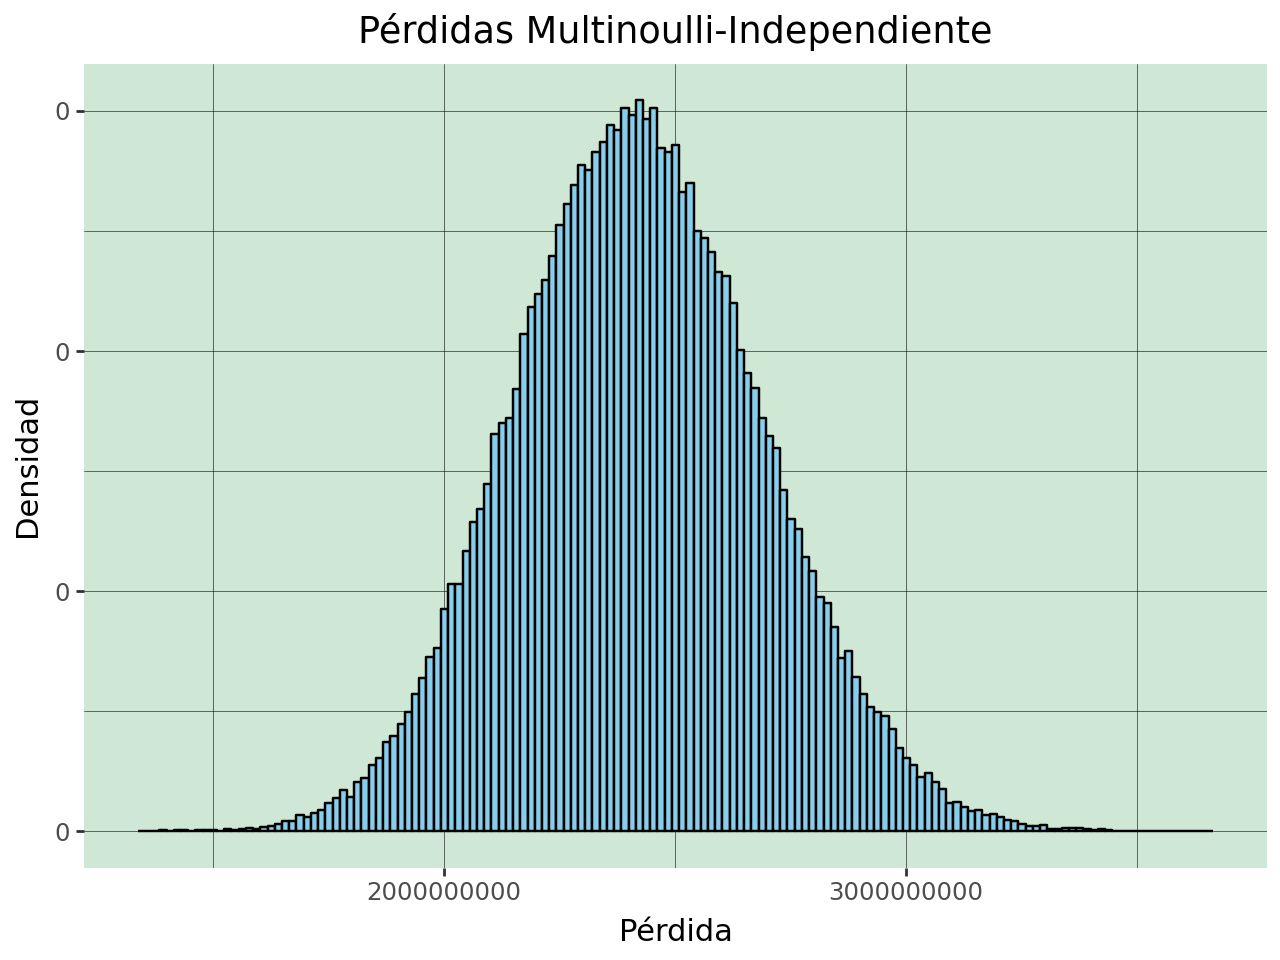

In [9]:
img_Multinoulli_dep = (ggplot(procesos_MonteCarlo_Severidad_dep, aes(x='SeveridadAcumulada', y='..density..')) +
    geom_histogram(fill='skyblue', color='black') +
    labs(
        title = "Pérdidas Multinoulli-Independiente",
        x="Pérdida",
        y="Densidad"
    ) +
    theme(
        panel_background=element_rect(fill="#cfe8d6", color=None),
        panel_grid=element_line(color="black", size=0.2)
    )
 )

img_Multinoulli_dep.save(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_dep", width=8, height=6, dpi=300)
img_Multinoulli_dep

C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_ind_ind
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 141'. Pick better value with 'binwidth'.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 141'. Pick better value with 'binwidth'.


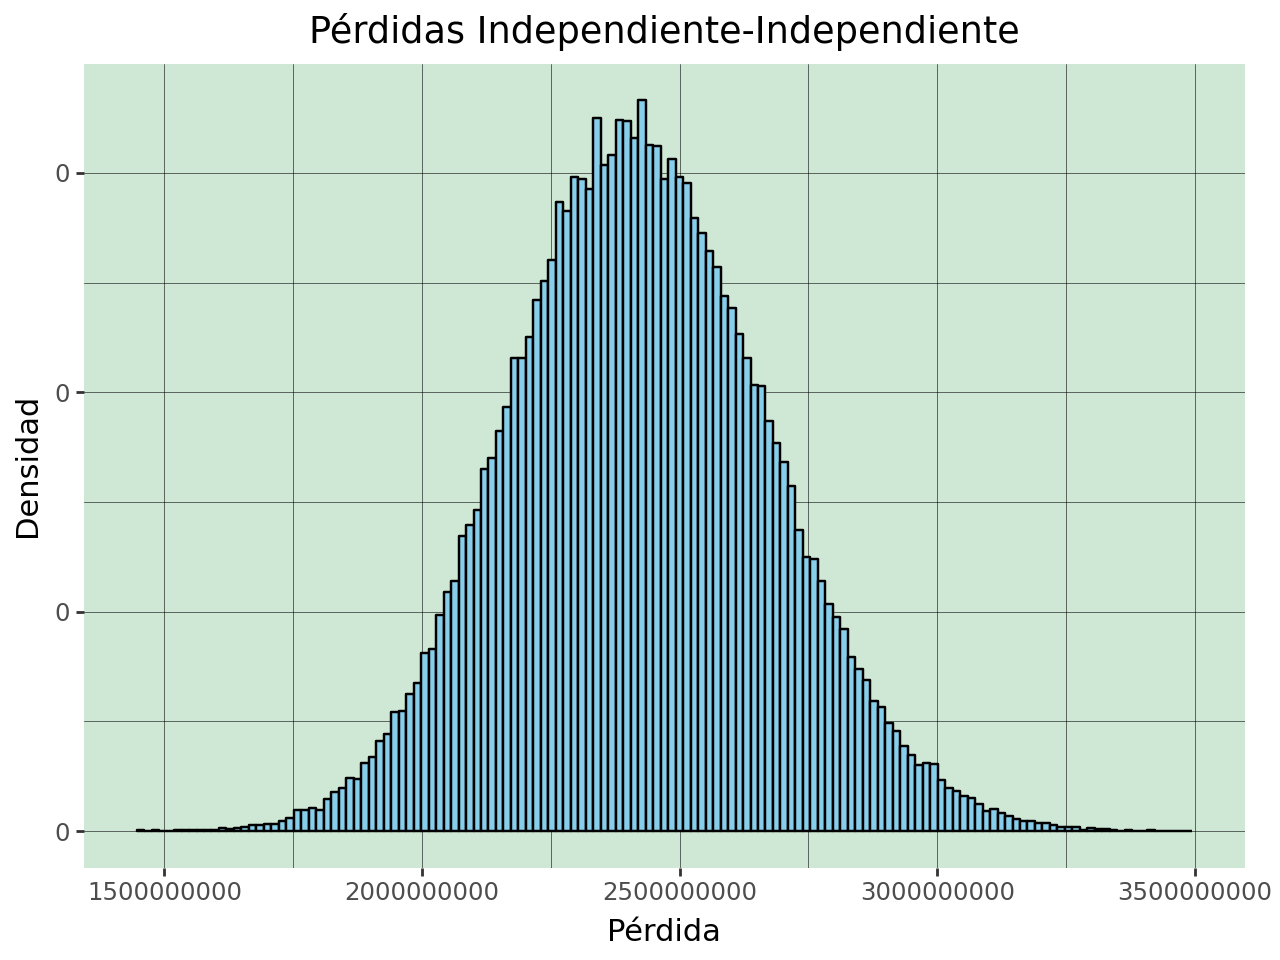

In [10]:
img_ind_ind = (ggplot(procesos_MonteCarlo_Severidad_ind, aes(x='SeveridadAcumulada_ind', y='..density..')) +
    geom_histogram(fill='skyblue', color='black') +
    labs(
        title = "Pérdidas Independiente-Independiente",
        x="Pérdida",
        y="Densidad"
    ) +
    theme(
        panel_background=element_rect(fill="#cfe8d6", color=None),
        panel_grid=element_line(color="black", size=0.2)
    )
 )

img_ind_ind.save(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_ind_ind", width=8, height=6, dpi=300)
img_ind_ind

In [11]:
VaR = procesos_MonteCarlo_Severidad_dep['SeveridadAcumulada'].quantile(0.95)
VaR_ind = procesos_MonteCarlo_Severidad_ind['SeveridadAcumulada_ind'].quantile(0.95)

TVaR = procesos_MonteCarlo_Severidad_dep[procesos_MonteCarlo_Severidad_dep['SeveridadAcumulada'] > VaR]['SeveridadAcumulada'].mean()
TVaR_ind = procesos_MonteCarlo_Severidad_ind[procesos_MonteCarlo_Severidad_ind['SeveridadAcumulada_ind'] > VaR]['SeveridadAcumulada_ind'].mean()

# Cópula arquimediana

In [12]:
n = procesos_MonteCarlo.shape[0] # Tamaño de simulacion
theta = 1.0   # dependencia
m1, s1 = 16, 0.002
m2, s2 = 17, 0.003

fx = (s1, 0.0, np.exp(m1))
fy = (s2, 0.0, np.exp(m2))

## --- Cópula Gumbel con tu θ ---
theta = 2.0   # ajusta a tu caso (>= 1)
cop = GumbelCopula(theta=theta, k_dim=2)

# Simula U ~ C_gumbel(θ)
U = cop.rvs(nobs=n, random_state=2025)   # matriz (n,2) con uniformes dependientes

# Obtenemos la distribucion conjunta usando PPF (Percent Point Function)
# ie, la inversa de la CDF x=F^{-1}(u)
X1 = st.lognorm.ppf(U[:,0], *fx)
X2 = st.lognorm.ppf(U[:,1], *fy)

simulaciones = pd.DataFrame({"X1_copula":X1, "X2_copula":X2})

simulaciones

,X1_copula,X2_copula
0,8.907219e+06,2.409204e+07
1,8.900033e+06,2.421330e+07
2,8.893011e+06,2.399288e+07
3,8.877411e+06,2.419939e+07
4,8.892742e+06,2.414715e+07
...,...,...
16798356,8.901237e+06,2.414299e+07
16798357,8.884421e+06,2.406014e+07
16798358,8.871034e+06,2.411347e+07
16798359,8.874190e+06,2.409044e+07


In [13]:
procesos_MonteCarlo_sinIndice = procesos_MonteCarlo.reset_index(drop=True)
simulaciones_sinIndice = simulaciones.reset_index(drop=True)
procesos_MonteCarlo_extendido = pd.concat([procesos_MonteCarlo_sinIndice, simulaciones_sinIndice], axis=1)

In [14]:
procesos_MonteCarlo_extendido

,Unnamed: 0,t,Xt,Proceso,I1,I2,I1_ind,I2_ind,X1,X2,Severidad1,Severidad2,Severidad1_ind,Severidad2_ind,Trayectoria,X1_copula,X2_copula
0,0,0.038053,1,1,0,0,0,0,8.894778e+06,2.419305e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,8.907219e+06,2.409204e+07
1,1,0.175528,2,1,1,0,1,0,8.881306e+06,2.416811e+07,8.881306e+06,0.000000e+00,8.881306e+06,0.000000e+00,0,8.900033e+06,2.421330e+07
2,2,0.302670,3,1,0,0,0,1,8.901672e+06,2.409192e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.409192e+07,0,8.893011e+06,2.399288e+07
3,0,0.306964,1,3,0,1,0,1,8.877121e+06,2.411341e+07,0.000000e+00,2.411341e+07,0.000000e+00,2.411341e+07,0,8.877411e+06,2.419939e+07
4,0,0.353692,1,2,0,0,0,1,8.904756e+06,2.416461e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.416461e+07,0,8.892742e+06,2.414715e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16798356,37,11.686291,38,2,1,1,1,0,8.871444e+06,2.404592e+07,8.871444e+06,2.404592e+07,8.871444e+06,0.000000e+00,99999,8.901237e+06,2.414299e+07
16798357,59,11.753534,60,1,0,0,0,0,8.885467e+06,2.425190e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99999,8.884421e+06,2.406014e+07
16798358,60,11.755571,61,1,0,0,0,0,8.883036e+06,2.415878e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99999,8.871034e+06,2.411347e+07
16798359,84,11.783520,85,3,0,1,0,1,8.890774e+06,2.415371e+07,0.000000e+00,2.415371e+07,0.000000e+00,2.415371e+07,99999,8.874190e+06,2.409044e+07


In [15]:
procesos_MonteCarlo_copula_dep = (procesos_MonteCarlo_extendido >>
                                  mutate(Severidad1_copula_dep = _.X1_copula*_.I1,
                                         Severidad2_copula_dep = _.X2_copula*_.I2,
                                         Severidad_step = _.Severidad1_copula_dep + _.Severidad2_copula_dep) >>
                                  group_by(_.Trayectoria) >>
                                  summarize(PerdidaFinal_copula_dep = _.Severidad_step.sum())
                                  )

procesos_MonteCarlo_copula_ind = (procesos_MonteCarlo_extendido >>
                                  mutate(Severidad1_copula_ind = _.X1_copula*_.I1_ind,
                                         Severidad2_copula_ind = _.X2_copula*_.I2_ind,
                                         Severidad_step = _.Severidad1_copula_ind + _.Severidad2_copula_ind) >>
                                  group_by(_.Trayectoria) >>
                                  summarize(PerdidaFinal_copula_ind = _.Severidad_step.sum())
                                  )

C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_copula
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 149'. Pick better value with 'binwidth'.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 149'. Pick better value with 'binwidth'.


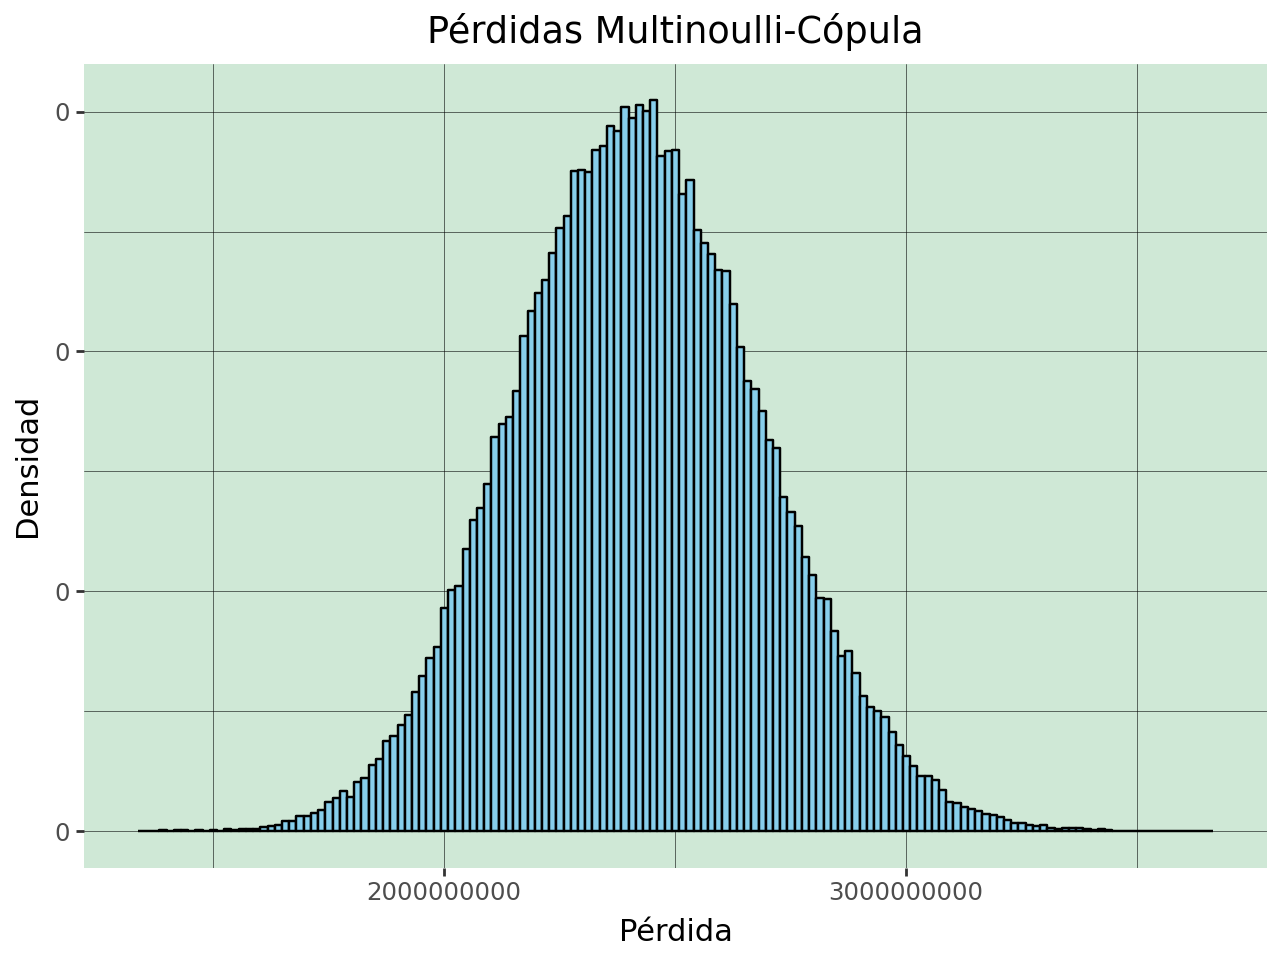

In [16]:
img_Multinoulli_copula = (ggplot(procesos_MonteCarlo_copula_dep, aes(x='PerdidaFinal_copula_dep', y='..density..')) +
    geom_histogram(fill='skyblue', color='black') +
    labs(
        title = "Pérdidas Multinoulli-Cópula",
        x="Pérdida",
        y="Densidad"
    ) +
    theme(
        panel_background=element_rect(fill="#cfe8d6", color=None),
        panel_grid=element_line(color="black", size=0.2)
    )
 )

img_Multinoulli_copula.save(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_copula", width=8, height=6, dpi=300)
img_Multinoulli_copula

## Ajuste paramétrico

C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_copula_normal
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 149'. Pick better value with 'binwidth'.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 149'. Pick better value with 'binwidth'.


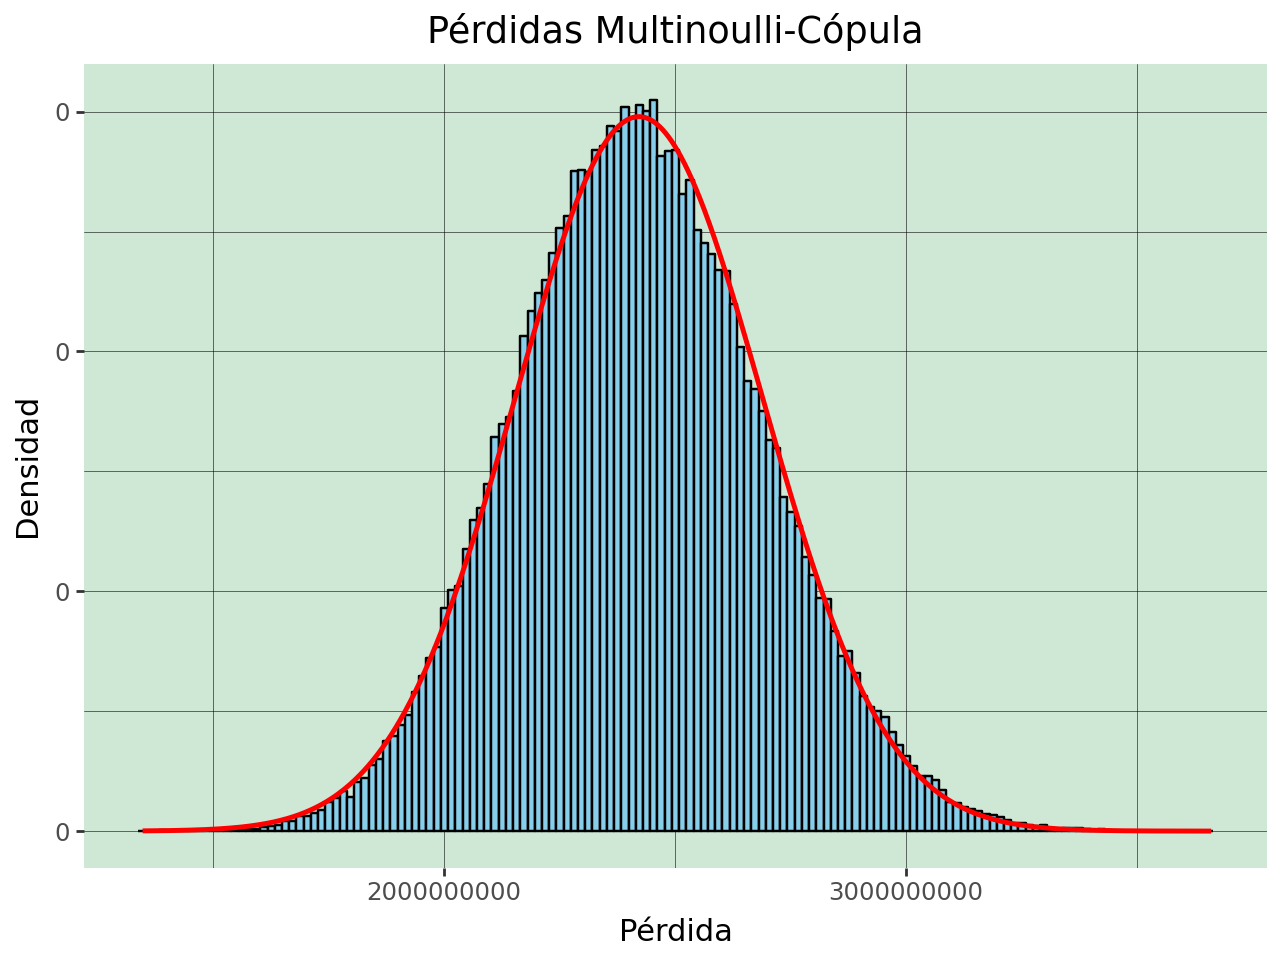

In [17]:
# Parametros de la normal
mu_PerdidaFinal_copula_dep = np.mean(procesos_MonteCarlo_copula_dep["PerdidaFinal_copula_dep"])
sigma_PerdidaFinal_copula_dep = np.std(procesos_MonteCarlo_copula_dep["PerdidaFinal_copula_dep"], ddof=1)

# Preparando para graficar la normal
max_PerdidaFinal_copula_dep = np.max(procesos_MonteCarlo_copula_dep["PerdidaFinal_copula_dep"])
min_PerdidaFinal_copula_dep = np.min(procesos_MonteCarlo_copula_dep["PerdidaFinal_copula_dep"])
x_val = np.linspace(min_PerdidaFinal_copula_dep, max_PerdidaFinal_copula_dep, 100000)
y_val = norm.pdf(x_val, mu_PerdidaFinal_copula_dep, sigma_PerdidaFinal_copula_dep)
normal = pd.DataFrame({'x':x_val, 'y':y_val})

img_Multinoulli_copula_normal = (ggplot() +
    geom_histogram(data=procesos_MonteCarlo_copula_dep, mapping = aes(x='PerdidaFinal_copula_dep', y='..density..'), fill='skyblue', color='black') +
    geom_line(data=normal, mapping = aes(x='x', y='y'), color='red', size=1) +
    labs(
        title = "Pérdidas Multinoulli-Cópula",
        x="Pérdida",
        y="Densidad"
    ) +
    theme(
        panel_background=element_rect(fill="#cfe8d6", color=None),
        panel_grid=element_line(color="black", size=0.2)
    )
 )

img_Multinoulli_copula_normal.save(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_copula_normal", width=8, height=6, dpi=300)
img_Multinoulli_copula_normal

In [18]:
# Imprimiendo los estimadores de la normal

print(mu_PerdidaFinal_copula_dep)
print(sigma_PerdidaFinal_copula_dep)

2421465067.3316345
267811078.89713284


In [19]:
# Obteniendo el estimador del VaR normal

q95_normal = mu_PerdidaFinal_copula_dep + sigma_PerdidaFinal_copula_dep*1.64485
q95_normal

np.float64(2861974120.4555836)

In [20]:
tamaño = 30

p_values = []
for i in range(tamaño):
    muestra = procesos_MonteCarlo_copula_dep["PerdidaFinal_copula_dep"].sample(5000, random_state=i)
    shap, p = shapiro(muestra)
    p_values.append(p)

np.mean(p_values)

np.float64(0.056888531378676416)

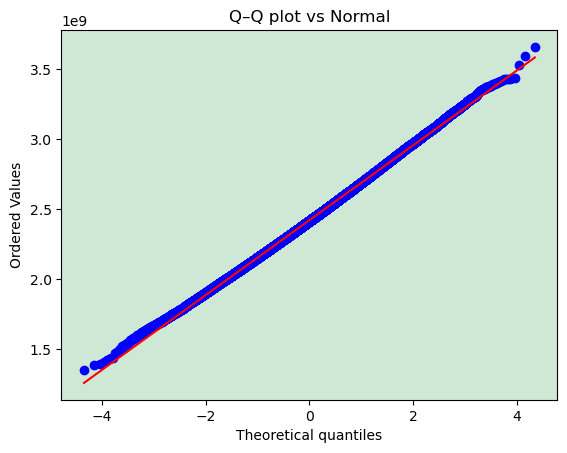

In [21]:
datos = procesos_MonteCarlo_copula_dep["PerdidaFinal_copula_dep"]

stats.probplot(datos, dist="norm", plot=plt)
plt.title("Q–Q plot vs Normal")
plt.gca().set_facecolor("#cfe8d6")
plt.savefig(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_QQplot_Normal.png",
            dpi=300, bbox_inches="tight")
plt.show()

2873426429.3917627


C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_cola_der
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 53'. Pick better value with 'binwidth'.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 53'. Pick better value with 'binwidth'.


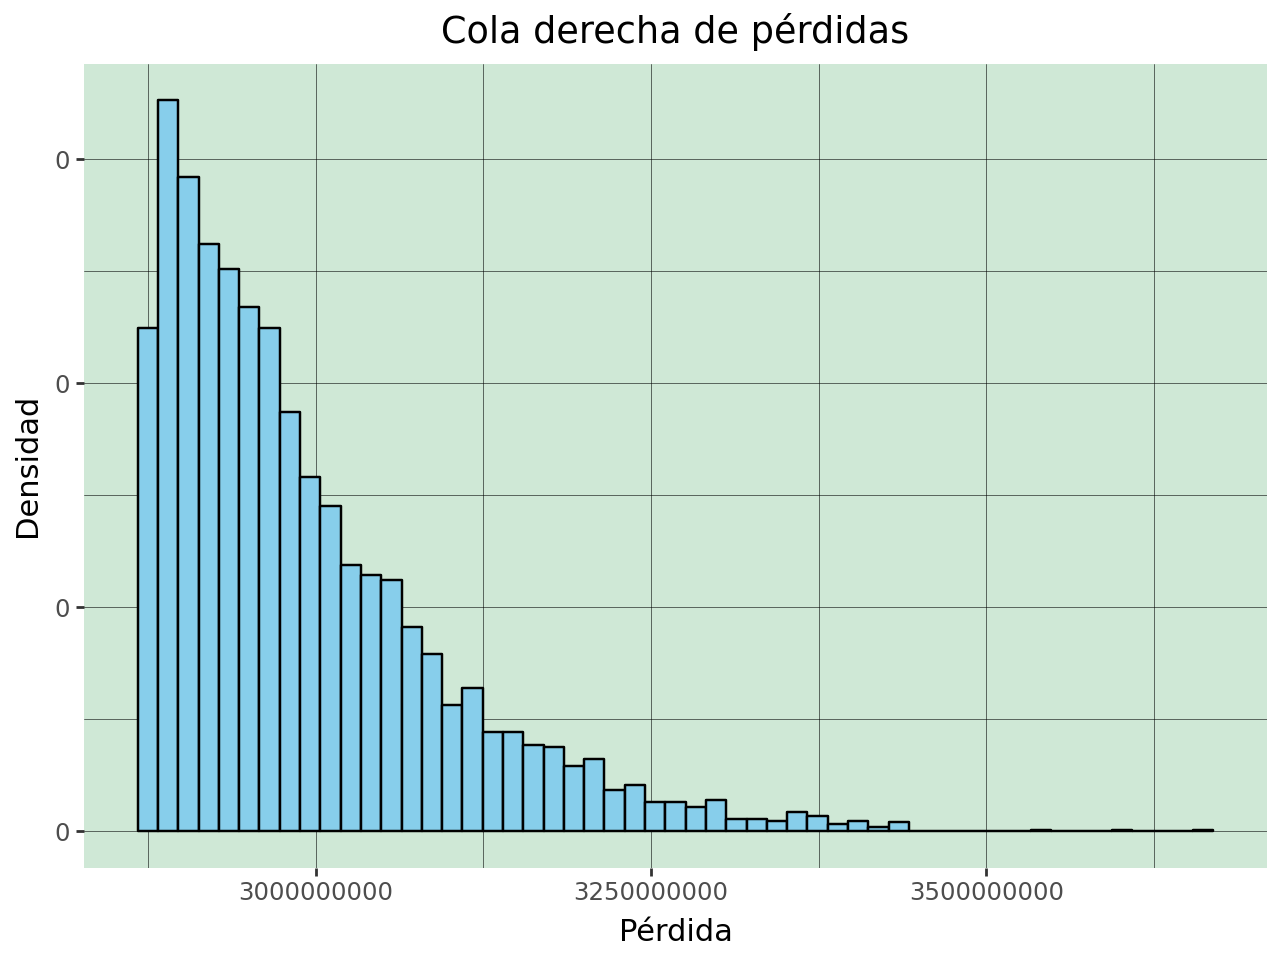

In [22]:
# Valores después del cuantil 0.95

q95 = np.quantile(procesos_MonteCarlo_copula_dep["PerdidaFinal_copula_dep"], 0.95)
valores_q95 = procesos_MonteCarlo_copula_dep[procesos_MonteCarlo_copula_dep["PerdidaFinal_copula_dep"] > q95]
print(q95)

img_Multinoulli_cola_der = (ggplot() +
 geom_histogram(data=valores_q95, mapping=aes(x="PerdidaFinal_copula_dep", y='..density..'), fill='skyblue', color='black') +
    labs(
        title = "Histograma de pérdidas, cola derecha",
        x="Pérdida",
        y="Densidad"
    ) +
 theme(
        panel_background=element_rect(fill="#cfe8d6", color=None),
        panel_grid=element_line(color="black", size=0.2)
    )
)

img_Multinoulli_cola_der.save(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_cola_der", width=8, height=6, dpi=300)
img_Multinoulli_cola_der

Ajustando una distribución Gumbel

$$ f(t; \mu, \lambda) = \frac{1}{\lambda} exp(-\frac{t-\mu}{\lambda})exp(-exp(-\frac{t-\mu}{\lambda})) $$
Entonces
$$ F(t;\mu,\lambda) = exp(-exp(-\frac{t-\mu}{\lambda})) $$

Sea $z = ln(-ln(F(t)))$ \
Entonces $ z = -\frac{t-\mu}{\lambda} = \frac{\mu}{\lambda} - \frac{1}{\lambda} t $\
Tomamos el modelo $ y=\beta_0 + \beta_1 x $\
Donde $ y=ln(-ln(F(t))) $\
$ \beta_0 = \frac{\mu}{\lambda} $\
$ \beta_1 = - \frac{1}{\lambda} $\
$ x=t $

In [23]:
# Construimos la funcion de distribucion acumulada

n = valores_q95.shape[0]

regresionLineal = (valores_q95 >>
                   arrange(-_.PerdidaFinal_copula_dep) >>
                   mutate(i=range(1,n+1),
                          St = _.i/(n+0.00000000001), # sumamos 1*10^{-11} porque en la perdida mas grande Ft da infinito
                          Ft = 1 - _. St,
                          y = np.log(-np.log(_.Ft)),
                          const = 1)
                  )

regresionLineal.head()

,Trayectoria,PerdidaFinal_copula_dep,i,St,Ft,y,const
65593,65593,3.660261e+09,1,0.0002,0.9998,-8.517093,1
52483,52483,3.597689e+09,2,0.0004,0.9996,-7.823846,1
61370,61370,3.534227e+09,3,0.0006,0.9994,-7.418281,1
41269,41269,3.441469e+09,4,0.0008,0.9992,-7.130499,1
66097,66097,3.440605e+09,5,0.0010,0.9990,-6.907255,1


C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_ajuste_cola_der


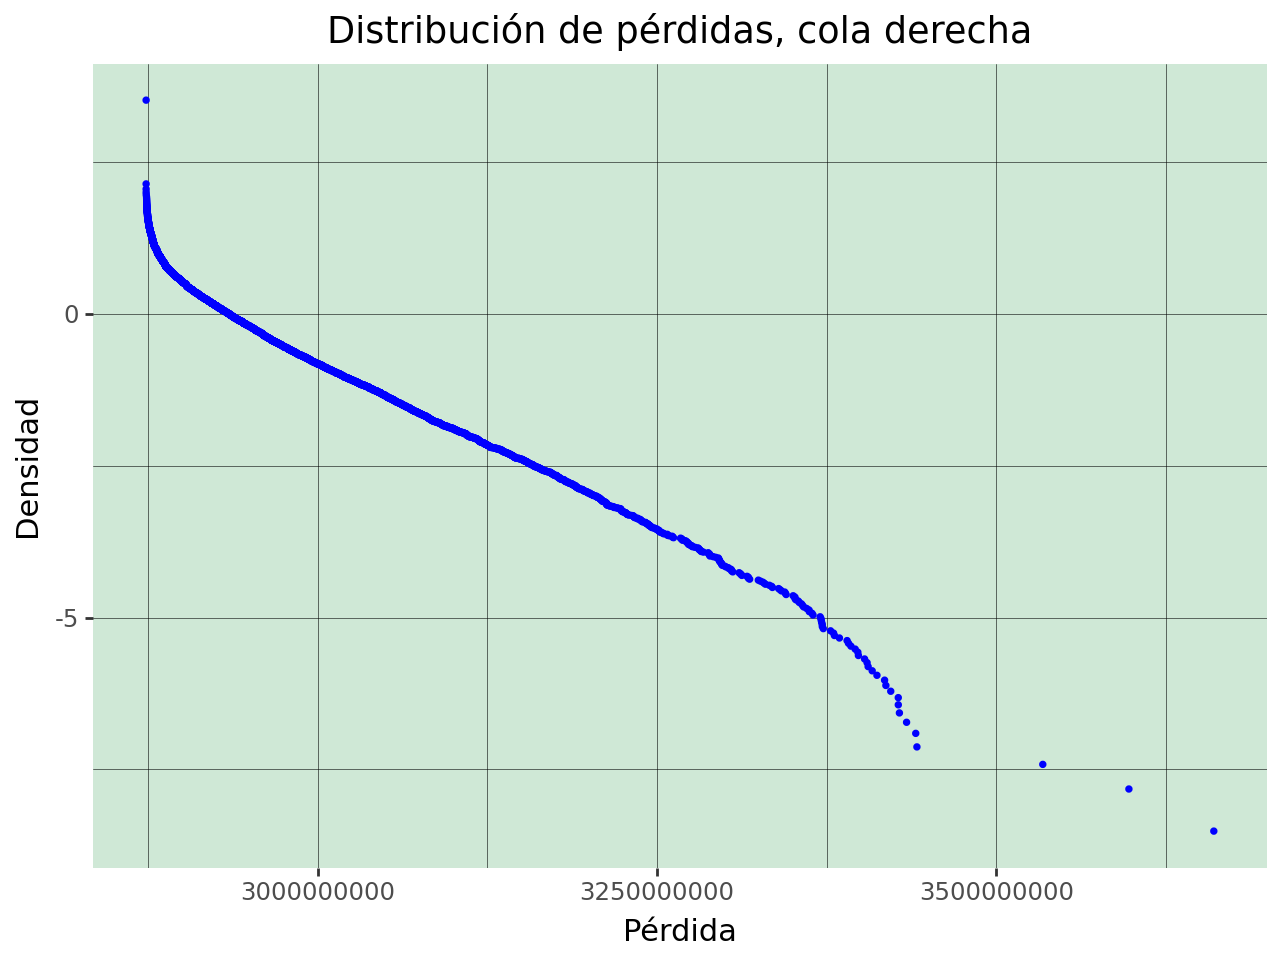

In [24]:
img_Multinoulli_ajuste_cola_der = (ggplot(regresionLineal) +
 geom_point(aes(x='PerdidaFinal_copula_dep', y='y'), color='blue', size=0.5) +
    labs(
        title = "Distribución de pérdidas, cola derecha",
        x="Pérdida",
        y="Densidad"
    ) +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2))
)

img_Multinoulli_ajuste_cola_der.save(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_ajuste_cola_der", width=8, height=6, dpi=300)
img_Multinoulli_ajuste_cola_der

In [25]:
# Hacemos la regresión lineal

predictors = ["const", "PerdidaFinal_copula_dep"]
target = "y"
fit = sm.OLS(regresionLineal[target], regresionLineal[predictors]).fit()
display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 2.458e+05
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:05:42   Log-Likelihood:                 1460.6
No. Observations:                5000   AIC:                            -2917.
Df Residuals:                    4998   BIC:                            -2904.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      35.9286      0.074    487.639      0.000      35.784      36.073
PerdidaFinal_copula_dep -1.221e-08   2.46e-11   -495.751      0.000   -1.23e-08   -1.22e-08
==============================================================================
Omnibus:                     3104.634   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58613.934
Skew:                           2.634   Prob(JB):                         0.00
Kurtosis:                      18.925   Cond. No.                     8.63e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.63e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
betas = fit.params
lambGumbel = -1/betas[1]
muGumbel = -betas[0]/betas[1]

print(f"lambda={lambGumbel}\nmu={muGumbel}")

lambda=81917443.35644196
mu=2943175575.263365


C:\Users\yaolu\AppData\Local\Temp\ipykernel_10512\2512294843.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\yaolu\AppData\Local\Temp\ipykernel_10512\2512294843.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [27]:
# Estimando el TVaR

TVaR_Normal = muGumbel + lambGumbel*0.5772
TVaR_Normal

np.float64(2990458323.568703)

C:\Users\yaolu\AppData\Local\Temp\ipykernel_10512\1625317791.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_ajuste_cola_der_comp


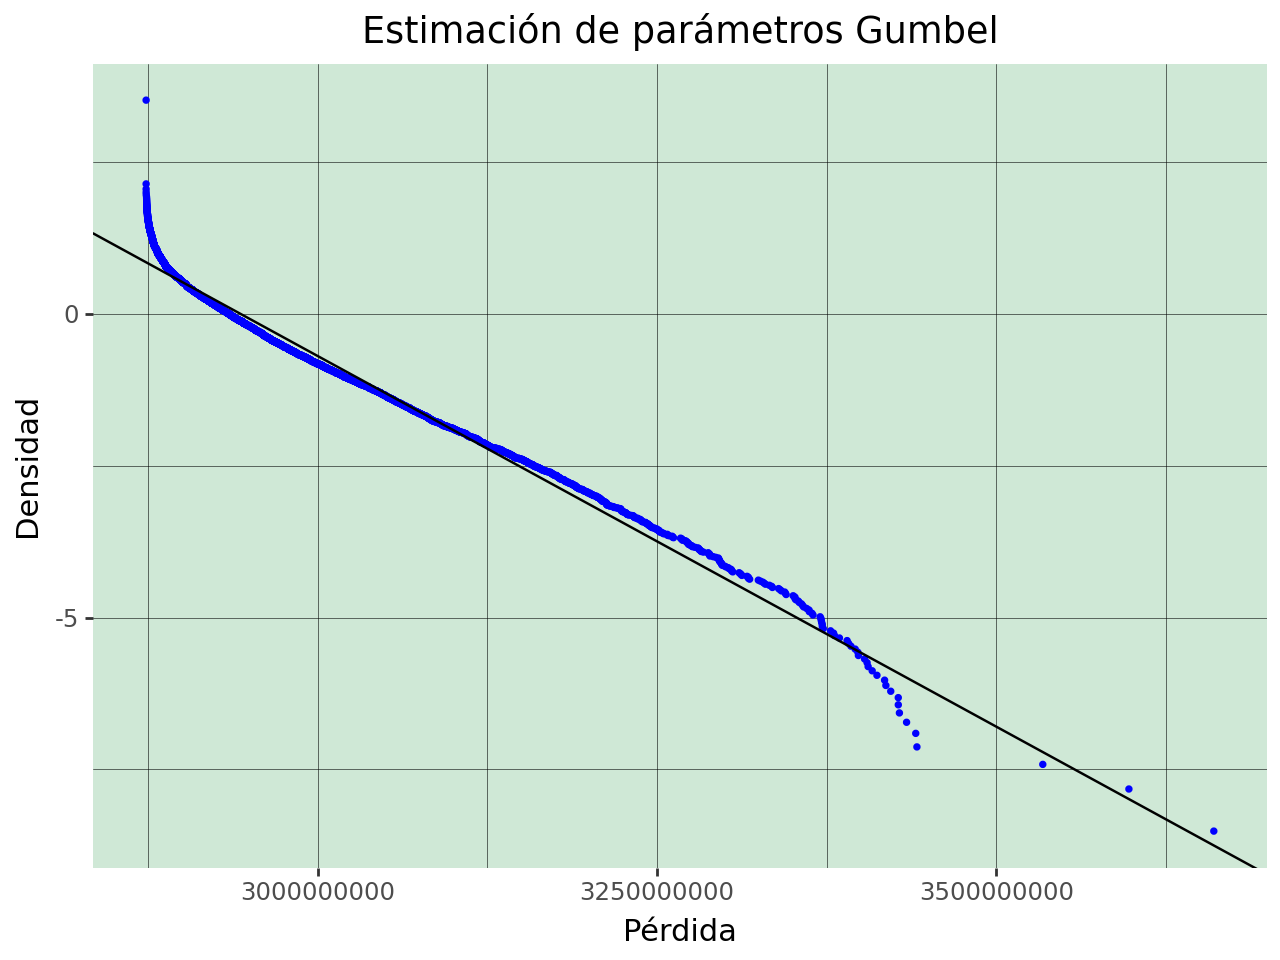

In [35]:
img_Multinoulli_ajuste_cola_der_comp = (ggplot(regresionLineal) +
 geom_point(mapping=aes(x='PerdidaFinal_copula_dep', y='y'), color='blue', size=0.5) +
 geom_abline(intercept=betas[0], slope=betas[1]) +
    labs(
        title = "Estimación de parámetros Gumbel",
        x="Pérdida",
        y="Densidad"
    ) +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2))
 )

img_Multinoulli_ajuste_cola_der_comp.save(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_Multinoulli_ajuste_cola_der_comp", width=8, height=6, dpi=300)
img_Multinoulli_ajuste_cola_der_comp

## Otros modelos

C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_ind_copula
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 141'. Pick better value with 'binwidth'.
C:\Users\yaolu\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 141'. Pick better value with 'binwidth'.


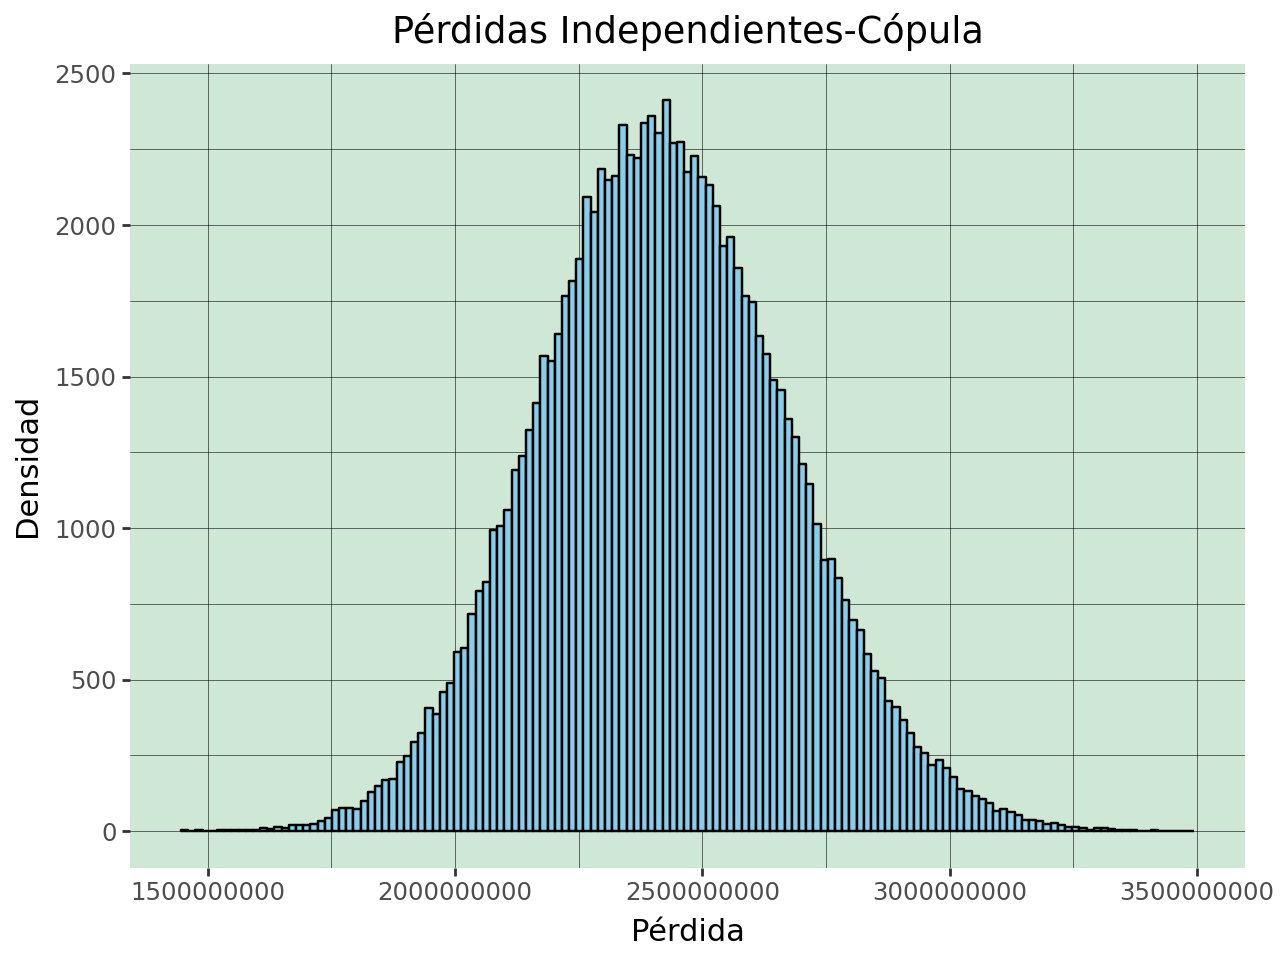

In [30]:
img_ind_copula = (ggplot(procesos_MonteCarlo_copula_ind, aes(x='PerdidaFinal_copula_ind')) +
    geom_histogram(fill='skyblue', color='black') +
    labs(
        title = "Pérdidas Independientes-Cópula",
        x="Pérdida",
        y="Densidad"
    ) +
    theme(
        panel_background=element_rect(fill="#cfe8d6", color=None),
        panel_grid=element_line(color="black", size=0.2)
    )
 )

img_ind_copula.save(r"C:\Users\yaolu\Documents\Métodos MonteCarlo Aplicados\Titulación\img_ind_copula", width=8, height=6, dpi=300)
img_ind_copula

In [31]:
VaR_copula_dep = procesos_MonteCarlo_copula_dep['PerdidaFinal_copula_dep'].quantile(0.95)
VaR_copula_ind = procesos_MonteCarlo_copula_ind['PerdidaFinal_copula_ind'].quantile(0.95)

TVaR_copula_dep = procesos_MonteCarlo_copula_dep[procesos_MonteCarlo_copula_dep['PerdidaFinal_copula_dep'] > VaR_copula_dep]['PerdidaFinal_copula_dep'].mean()
TVaR_copula_ind = procesos_MonteCarlo_copula_ind[procesos_MonteCarlo_copula_ind['PerdidaFinal_copula_ind'] > VaR_copula_ind]['PerdidaFinal_copula_ind'].mean()

In [32]:
metricas =pd.DataFrame({"Tipo":["Independientes",
                                "Dependientes",
                                "Copula_independientes",
                                "Copula_dependientes"],
                        "VaR":[VaR_ind, 
                               VaR,
                               VaR_copula_ind,
                               VaR_copula_dep],
                        "TVaR":[TVaR_ind,
                                TVaR,
                                TVaR_copula_ind,
                                TVaR_copula_dep]})
metricas

,Tipo,VaR,TVaR
0,Independientes,2.842642e+09,2.981835e+09
1,Dependientes,2.873350e+09,2.990328e+09
2,Copula_independientes,2.842420e+09,2.954517e+09
3,Copula_dependientes,2.873426e+09,2.990336e+09


In [33]:
metricas >> arrange(-_.VaR)

,Tipo,VaR,TVaR
3,Copula_dependientes,2.873426e+09,2.990336e+09
1,Dependientes,2.873350e+09,2.990328e+09
0,Independientes,2.842642e+09,2.981835e+09
2,Copula_independientes,2.842420e+09,2.954517e+09


In [34]:
metricas >> arrange(-_.TVaR)

,Tipo,VaR,TVaR
3,Copula_dependientes,2.873426e+09,2.990336e+09
1,Dependientes,2.873350e+09,2.990328e+09
0,Independientes,2.842642e+09,2.981835e+09
2,Copula_independientes,2.842420e+09,2.954517e+09
